**Embeddings que tenemos**
* Secuencia
  * seqvec
  * ProtT5
  * ProtBERT
* Estructura
  * Prost5

**Combinaciones que probaremos**
1. seqvec
2. ProtT5
3. ProtBERT
4. Prost5
5. Prost5 - seqvec
6. Prost5 -ProtT5
7. Prost5 -ProtBERT

**Algoritmos que usaremos**

1. SVR
2. RF
3. Red neuronal
  * 3-4 capas densas
4. XGBOOST
5. light 

En este archivo se está llevando a cabo esta combinación:

 5. Prost5 - seqvec

In [1]:
##pip install xgboost tensorflow lightgbm
##pip install seaborn
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import random
import timeit
import torch
import xgboost
import tensorflow
import lightgbm
import copy 
import openpyxl


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time


# Regressors
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA

# Métricas de regresión
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Otras utilidades
from pandas import DataFrame
import matplotlib.pyplot as plt
print("loaded")

2025-05-11 16:28:07.954306: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 16:28:07.996812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 16:28:08.726197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


loaded


In [2]:
# Ruta base
base_dir = "/home/sis.virtual.uniandes.edu.co/as.villa/proyecto"

# 1. Carga las tablas con IDs y TM-scores
df_train = pd.read_csv(os.path.join(base_dir, "data/preprocessed_data/train_preprocessed.txt"))
df_val   = pd.read_csv(os.path.join(base_dir, "data/preprocessed_data/val_preprocessed.txt"))
df_test  = pd.read_csv(os.path.join(base_dir, "data/preprocessed_data/test_preprocessed.txt"))

# 2. Directorios de embeddingsproyecto/embeddings/ProtT5_XL_U50
seq1_dirs = {
    "train": os.path.join(base_dir, "embeddings/ProtT5_XL_U50/train"),##modificar para otras combinaciones
    "val":   os.path.join(base_dir, "embeddings/ProtT5_XL_U50/val"),
    "test":  os.path.join(base_dir, "embeddings/ProtT5_XL_U50/test")
}

#seq2_dirs = {
#    "train": os.path.join(base_dir, "embeddings/structure_embeddings/train"),##modificar para otras combinaciones
#    "val":   os.path.join(base_dir, "embeddings/structure_embeddings/val"),
#    "test":  os.path.join(base_dir, "embeddings/structure_embeddings/test")
#}


print("Train:", df_train.info(), sep="\n")
print("Validation:", df_val.info(), sep="\n")
print("Test:", df_test.info(), sep="\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28743 entries, 0 to 28742
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Protein_ID       28743 non-null  object 
 1   Sequence         28743 non-null  object 
 2   Sequence_Length  28743 non-null  int64  
 3   Type             28743 non-null  object 
 4   Tm               28743 non-null  float64
 5   PDB_Path         28743 non-null  object 
 6   Unique_ID        28743 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB
Train:
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513 entries, 0 to 512
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Protein_ID       513 non-null    object 
 1   Sequence         513 non-null    object 
 2   Sequence_Length  513 non-null    int64  
 3   Type             513 non-null    object 
 4   Tm               51

In [3]:
def cargar_embeddings_seq1(df, seq1_dirs):
    seq_data = []
    tm_values = []

    for _, row in df.iterrows():
        pid = row["Protein_ID"] #3 modificar para otros
        uid =row["Unique_ID"]
        tm = row["Tm"]

        seq1_path = os.path.join(seq1_dirs, f"{uid}_ProtT5_XL_U50.npy") ####3modificar para otros

        try:
            seq1 = np.load(seq1_path)
            seq_data.append(seq1)
            tm_values.append(tm)

        except Exception as e:
            print(f"[ERROR] No se pudo procesar {uid}: {e}")

    X = np.array(seq_data)
    y = np.array(tm_values, dtype=float)

    return X, y



In [4]:
# Cargar train
X_train_og, y_train = cargar_embeddings_seq1(df_train, seq1_dirs["train"])

# Cargar val
X_val_og, y_val = cargar_embeddings_seq1(df_val, seq1_dirs["val"])

# Cargar test
X_test_og, y_test = cargar_embeddings_seq1(df_test, seq1_dirs["test"])

# Unir train y val para unos casos
X_trainval_og = np.concatenate([X_train_og, X_val_og])
y_trainval = np.concatenate([y_train, y_val])

# Verifica formas
print("Train:", X_train_og.shape, y_train.shape)
print("Val:", X_val_og.shape, y_val.shape)
print("Test:", X_test_og.shape, y_test.shape)
print("Train y val:", X_trainval_og.shape, y_trainval.shape)


Train: (28743, 1024) (28743,)
Val: (513, 1024) (513,)
Test: (523, 1024) (523,)
Train y val: (29256, 1024) (29256,)


Normalización

In [5]:
scaler = StandardScaler()
scaler.fit(X_train_og)  # solo entrenamiento

X_train = scaler.transform(X_train_og)
X_val = scaler.transform(X_val_og)
X_test = scaler.transform(X_test_og)
X_trainval = scaler.transform(X_trainval_og)


#### Data loader para la red neuronal

In [6]:
from torch.utils.data import Dataset
import numpy as np
import os

class ProteinTmDatasetSeq1(Dataset):
    def __init__(self, df, seq1_dir, transform=None):
        """
        df: DataFrame con columnas 'Unique_ID' y 'Tm'
        seq1_dir: directorio donde están los archivos 
        """
        self.df = df.reset_index(drop=True)
        self.seq1_dir = seq1_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        uid = row["Unique_ID"]
        tm = row["Tm"]

        # Cargar solo seq1
        seq1 = np.load(os.path.join(self.seq1_dir, f"{uid}_ProtT5_XL_U50.npy")).astype(np.float32)

        if self.transform:
            seq1 = self.transform(seq1)

        return seq1, np.float32(tm)

 

In [7]:
# Supongamos que ya tienes df_train, df_val, df_test y los dicts seq1_dirs, seq2_dirs
train_ds = ProteinTmDatasetSeq1(df_train, seq1_dirs["train"])
val_ds = ProteinTmDatasetSeq1(df_val, seq1_dirs["val"])
test_ds = ProteinTmDatasetSeq1(df_test, seq1_dirs["test"])


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


## SVR

In [8]:
## SVR Buscar mejores hiperparametros

def entrenar_svr(X_train, y_train, X_val, y_val, C=10, epsilon=0.03, kernel='rbf'): ###MOD SI NEC
    # Pipeline:  PCA (90%) + SVR
    pipeline = Pipeline([
        ("pca", PCA(n_components=0.90)),
        ("svr", SVR(C=C, epsilon=epsilon, kernel=kernel))
    ])

    start = timeit.default_timer()

    # Entrenar modelo
    pipeline.fit(X_train, y_train)

    # Predecir
    y_pred = pipeline.predict(X_val)

    stop = timeit.default_timer()
    elapsed = stop - start

    # Métricas
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"SVR entrenado con C={C}, epsilon={epsilon}, kernel={kernel}")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Tiempo: {elapsed:.2f} s")

    return pipeline, [mse, mae, r2, elapsed]


modelo_svr, resultados_svr = entrenar_svr(X_trainval, y_trainval, X_test, y_test)

SVR entrenado con C=10, epsilon=0.03, kernel=rbf
MSE: 52.7137, MAE: 5.4969, R²: 0.8200, Tiempo: 811.23 s


## RF REGRESSOR

In [9]:
##RF
def entrenar_rf(X_train, y_train, X_val, y_val,
                n_estimators, max_depth,
                min_samples_split, min_samples_leaf): ##MOD HP
    pipeline = Pipeline([
        ("rf", RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            n_jobs=-1,
            random_state=42
        ))
    ])

    start = timeit.default_timer()

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)

    stop = timeit.default_timer()
    elapsed = stop - start

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"RandomForest entrenado con n_estimators={n_estimators}, max_depth={max_depth}")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Tiempo: {elapsed:.2f} s")

    return pipeline, [mse, mae, r2, elapsed]

n_estimators = 200            # Más árboles ayudan con la estabilidad (200 es buen compromiso)
max_depth = 25                # Profundidad razonable para evitar sobreajuste
min_samples_split = 5         # Evita splits innecesarios
min_samples_leaf = 2          # Mejora generalización

modelo_rf, resultados_rf = entrenar_rf(
    X_trainval, y_trainval, X_test, y_test,
    n_estimators,
    max_depth,
    min_samples_split,
    min_samples_leaf
    )

RandomForest entrenado con n_estimators=200, max_depth=25
MSE: 77.2673, MAE: 6.7037, R²: 0.7362, Tiempo: 318.04 s


## XGBOOST

In [10]:
def entrenar_xgboost(X_train, y_train, X_val, y_val,
                     n_estimators, max_depth,
                     learning_rate, subsample,
                     colsample_bytree):
    
    modelo = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    start = timeit.default_timer()

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_val)

    stop = timeit.default_timer()
    elapsed = stop - start

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"XGBoost entrenado con n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Tiempo: {elapsed:.2f} s")

    return modelo, [mse, mae, r2, elapsed]

n_estimators = 300            # Árboles suficientes para converger ## A ESTE SE le puede bajar def 100
max_depth = 6                 # Controla complejidad (menos que RF) ==def
learning_rate = 0.03          # Aprendizaje más lento = más generalización 
subsample = 0.8               # Evita sobreajuste (80% de datos en cada árbol) def =1
colsample_bytree = 0.8        # Usar 80% de las columnas (útil con 2048 features) def =1

modelo_xgb, resultados_xgb = entrenar_xgboost(
    X_trainval, y_trainval, X_test, y_test,
    n_estimators,
    max_depth,
    learning_rate,
    subsample,
    colsample_bytree)


XGBoost entrenado con n_estimators=300, max_depth=6, learning_rate=0.03
MSE: 59.9603, MAE: 5.8674, R²: 0.7953, Tiempo: 23.39 s


## LIGHTGBM

In [11]:
def entrenar_lightgbm(X_train, y_train, X_val, y_val, objective,
                      n_estimators, max_depth,
                      learning_rate, num_leaves,
                      subsample, colsample_bytree):
    
    modelo = LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1
    )

    start = timeit.default_timer()

    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_val)

    stop = timeit.default_timer()
    elapsed = stop - start

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"LightGBM entrenado con n_estimators={n_estimators}, learning_rate={learning_rate}, num_leaves={num_leaves}")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Tiempo: {elapsed:.2f} s")

    return modelo, [mse, mae, r2, elapsed]

n_estimators = 300         # Más árboles para mejor ajuste
learning_rate = 0.03       # Más bajo = mejor generalización
max_depth = -1             # Sin límite de profundidad (útil con early stopping)
num_leaves = 64            # Más que el valor por defecto (31), útil con 2048 features
subsample = 1            # Muestreo de datos para evitar sobreajuste
colsample_bytree = 1     # Muestreo de columnas (features) por árbol
objective='regression'

modelo_lgb, resultados_lgb = entrenar_lightgbm(
    X_train, y_train, X_val, y_val, objective,
    n_estimators, max_depth, learning_rate,
    num_leaves, subsample, colsample_bytree
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 28743, number of used features: 1024
[LightGBM] [Info] Start training from score 58.821847
LightGBM entrenado con n_estimators=300, learning_rate=0.03, num_leaves=64
MSE: 81.4293, MAE: 7.0659, R²: 0.7219, Tiempo: 782.70 s


## Red Neuronal

In [12]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow está usando la GPU.")
    # Para ver más detalles de la GPU (opcional)
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"Nombre: {gpu.name}, Tipo: {gpu.device_type}")
    device = torch.device("cuda")  # Usa la GPU 2
    #model.to(device)
else:
    print("TensorFlow NO está usando la GPU, usará la CPU.")

Num GPUs Available:  1
TensorFlow está usando la GPU.
Nombre: /physical_device:GPU:0, Tipo: GPU


2025-05-11 17:00:31.690046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-11 17:00:31.726449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-11 17:00:31.726555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
def entrenar_red_neuronal(train_loader, val_loader, test_loader,
                           epochs=50, batch_size=32, learning_rate=1e-4,
                           device="cuda" if torch.cuda.is_available() else "cpu"):
    print("\n--- Entrenando Red Neuronal con PyTorch ---")
    print(f"Usando dispositivo: {device.upper()}")

    # Definir el modelo
    modelo = nn.Sequential(
        nn.Linear(1024, 1024), nn.ReLU(), ### cambió para solo un embedding de 1024
        nn.BatchNorm1d(1024), nn.Dropout(0.5),
        nn.Linear(1024, 512),  nn.ReLU(),
        nn.BatchNorm1d(512),  nn.Dropout(0.4),
        nn.Linear(512, 256),  nn.ReLU(),
        nn.Linear(256, 128),  nn.ReLU(),
        nn.Linear(128,   1)
    ).to(device)
    #modelo = nn.Sequential(
    #    nn.Linear(2048, 512), nn.ReLU(),
    #    nn.BatchNorm1d(512), nn.Dropout(0.3),
    #    nn.Linear(512, 128), nn.ReLU(),
    #    nn.BatchNorm1d(128), nn.Dropout(0.3),
    #    nn.Linear(128, 1)
    #).to(device)

    optimizer = optim.Adam(modelo.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.MSELoss()

    history = {
        "train_loss": [],
        "val_loss": []
    }

    start = time.time()

    best_model = None
    best_val_loss = float("inf")

    # Entrenamiento
    for epoch in range(1, epochs + 1):
        modelo.train()
        train_losses = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = modelo(X_batch).view(-1)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validación
        modelo.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = modelo(X_batch).view(-1)
                loss = criterion(y_pred, y_batch)
                val_losses.append(loss.item())

        train_loss_epoch = np.mean(train_losses)
        val_loss_epoch = np.mean(val_losses)
        history["train_loss"].append(train_loss_epoch)
        history["val_loss"].append(val_loss_epoch)

        # Guardar mejor modelo
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            best_model = copy.deepcopy(modelo)

        print(f"Época {epoch:02d} | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f}")

    # Evaluación final
    modelo = best_model
    modelo.eval()
    y_trues, y_preds = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            #y_pred = modelo(X_batch).squeeze().cpu().numpy()
            y_pred = modelo(X_batch).view(-1).cpu().numpy()
            y_preds.append(y_pred)
            y_trues.append(y_batch.numpy())

    y_pred = np.concatenate(y_preds)
    y_true = np.concatenate(y_trues)

    stop = time.time()
    elapsed = stop - start

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\nEvaluación final en test:")
    print(f"MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | Tiempo: {elapsed:.2f} s")

    return modelo, [mse, mae, r2, elapsed], history
  

In [14]:
modelo_nn, resultados_nn, history_nn = entrenar_red_neuronal(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=50,
    batch_size=32,
    learning_rate=1e-5
)


--- Entrenando Red Neuronal con PyTorch ---
Usando dispositivo: CUDA


/home/sis.virtual.uniandes.edu.co/as.villa/miniconda3/envs/bioembed/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Época 01 | Train Loss: 3089.1494 | Val Loss: 1505.6607
Época 02 | Train Loss: 524.9017 | Val Loss: 206.3890
Época 03 | Train Loss: 221.3651 | Val Loss: 135.5869
Época 04 | Train Loss: 184.4682 | Val Loss: 111.6649
Época 05 | Train Loss: 153.4447 | Val Loss: 100.2070
Época 06 | Train Loss: 134.3209 | Val Loss: 87.3177
Época 07 | Train Loss: 111.2546 | Val Loss: 83.7609
Época 08 | Train Loss: 96.1799 | Val Loss: 96.2011
Época 09 | Train Loss: 90.1074 | Val Loss: 85.5561
Época 10 | Train Loss: 81.4259 | Val Loss: 84.1660
Época 11 | Train Loss: 75.8670 | Val Loss: 77.0195
Época 12 | Train Loss: 69.4560 | Val Loss: 77.0591
Época 13 | Train Loss: 69.7630 | Val Loss: 78.5796
Época 14 | Train Loss: 64.9566 | Val Loss: 76.7487
Época 15 | Train Loss: 63.0121 | Val Loss: 73.4913
Época 16 | Train Loss: 61.5287 | Val Loss: 73.3721
Época 17 | Train Loss: 60.7822 | Val Loss: 73.1678
Época 18 | Train Loss: 58.6728 | Val Loss: 70.7080
Época 19 | Train Loss: 56.0868 | Val Loss: 75.3163
Época 20 | Train 

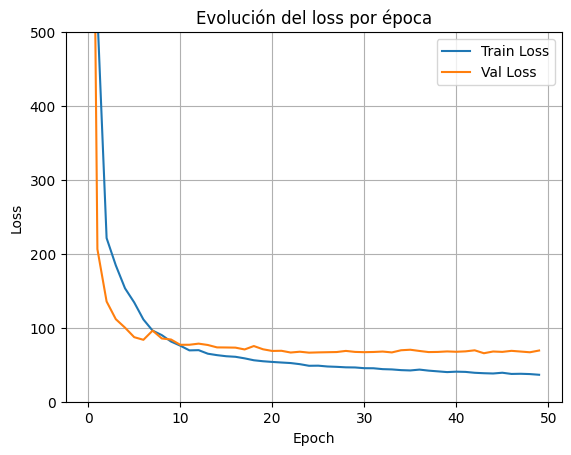

In [15]:
plt.plot(history_nn["train_loss"], label="Train Loss")
plt.plot(history_nn["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución del loss por época")
plt.legend()
plt.grid(True)
plt.ylim(0, 500) 
plt.show()


### RECOLECCIÓN DE RESULTADOS DE TODOS LOS MODELOS


--- TABLA COMPARATIVA DE RESULTADOS EN TEST ---
          Modelo        MSE       MAE        R2  Runtime (s)
0            SVR  52.713700  5.496891  0.820031   811.227529
1  Random Forest  77.267280  6.703727  0.736203   318.035887
2        XGBoost  59.960273  5.867438  0.795290    23.394359
3       LightGBM  81.429324  7.065937  0.721871   782.696086
4   Red Neuronal  52.912815  5.680414  0.819351    78.887432
--------------------------------------------------


/tmp/ipykernel_62175/4064859750.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y=metric, data=results_df, ax=ax, palette="viridis")
/tmp/ipykernel_62175/4064859750.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y=metric, data=results_df, ax=ax, palette="viridis")
/tmp/ipykernel_62175/4064859750.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y=metric, data=results_df, ax=ax, palette="viridis")
/tmp/ipykernel_62175/4064859750.py:83: FutureWarning: 

Passing `palette` without assigning `hue`

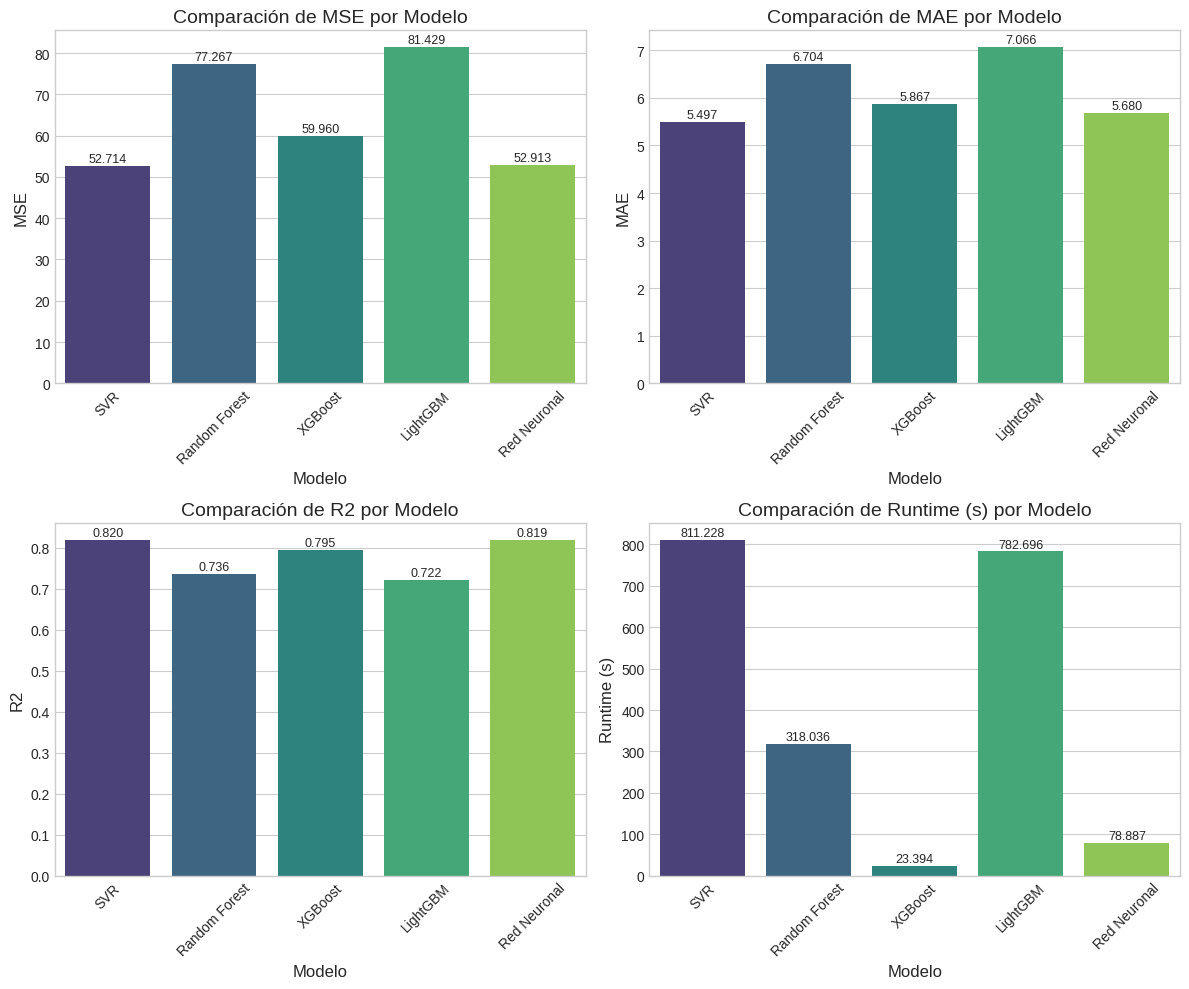

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
all_results = []
if 'resultados_svr' in locals(): # Verifica si la variable existe
    all_results.append({
        "Modelo": "SVR",
        "MSE": resultados_svr[0],
        "MAE": resultados_svr[1],
        "R2": resultados_svr[2],
        "Runtime (s)": resultados_svr[3]
    })

# Añadir resultados del Random Forest
if 'resultados_rf' in locals():
    all_results.append({
        "Modelo": "Random Forest",
        "MSE": resultados_rf[0],
        "MAE": resultados_rf[1],
        "R2": resultados_rf[2],
        "Runtime (s)": resultados_rf[3]
    })

# Añadir resultados del XGBoost
if 'resultados_xgb' in locals():
    all_results.append({
        "Modelo": "XGBoost",
        "MSE": resultados_xgb[0],
        "MAE": resultados_xgb[1],
        "R2": resultados_xgb[2],
        "Runtime (s)": resultados_xgb[3]
    })

# Añadir resultados del LightGBM
if 'resultados_lgb' in locals():
    all_results.append({
        "Modelo": "LightGBM",
        "MSE": resultados_lgb[0],
        "MAE": resultados_lgb[1],
        "R2": resultados_lgb[2],
        "Runtime (s)": resultados_lgb[3]
    })

# Añadir resultados de la Red Neuronal
# Asumiendo que tu función se llama entrenar_red_neuronal y la has ejecutado:
# modelo_nn, resultados_nn = entrenar_red_neuronal(X_trainval, y_trainval, X_test, y_test, X_test, y_test, epochs=50)
if 'resultados_nn' in locals(): # Renombra 'resultados_nn' según cómo lo hayas guardado
    all_results.append({
        "Modelo": "Red Neuronal",
        "MSE": resultados_nn[0],
        "MAE": resultados_nn[1],
        "R2": resultados_nn[2],
        "Runtime (s)": resultados_nn[3]
    })
else: # Si no se corrió la red neuronal, puedes añadir un placeholder o un mensaje
    print("Resultados de Red Neuronal no disponibles para visualización.")


# Convertir la lista de resultados a un DataFrame de Pandas
if all_results: # Solo si la lista no está vacía
    results_df = pd.DataFrame(all_results)
    print("\n--- TABLA COMPARATIVA DE RESULTADOS EN TEST ---")
    print(results_df)
    print("-" * 50)
    
    results_df.to_excel("ProtT5_XL.xlsx", index=False) ##################################################

    # ---------------------------------------------------------------------------
    # VISUALIZACIÓN DE MÉTRICAS
    # ---------------------------------------------------------------------------
    if not results_df.empty:
        plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráfico

        metrics_to_plot = ["MSE", "MAE", "R2", "Runtime (s)"]
        n_metrics = len(metrics_to_plot)
        n_cols = 2 # Puedes ajustar el número de columnas para los subplots
        n_rows = (n_metrics + n_cols - 1) // n_cols

        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 5))
        axes = axes.flatten() # Para acceder a los subplots de forma lineal

        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i]
            sns.barplot(x="Modelo", y=metric, data=results_df, ax=ax, palette="viridis")
            ax.set_title(f"Comparación de {metric} por Modelo", fontsize=14)
            ax.set_xlabel("Modelo", fontsize=12)
            ax.set_ylabel(metric, fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.3f}",
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 5),
                            textcoords='offset points', fontsize=9)

        # Ocultar ejes no utilizados si el número de métricas no es múltiplo de n_cols
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout() # Ajusta el layout para que no se solapen los títulos
        plt.show()

        # Si quieres guardar la figura
        # fig.savefig(os.path.join(base_dir, "models/comparacion_metricas.png"), dpi=300)
        # print("Gráfico de comparación de métricas guardado.")

    else:
        print("No hay resultados para graficar.")
else:
    print("No se generaron resultados para ningún modelo.")

In [1]:
! pip install openpyxl